# Plots for ablation study of data augmentation

This notebook constructs plots for the ablation study on data augmentatio in the report

In [1]:
import utils
import model
import matplotlib.pyplot as plt
import torch
import numpy as np
import pickle

In [2]:
dataset_name = 'facades'

In [3]:
# instantiate datasets and dataloaders
datasets = {'train': utils.ImageDataset(dataset_name = dataset_name, transform=utils.data_transforms['train'], mode = 'train'),
            'val': utils.ImageDataset(dataset_name = dataset_name, transform=None, mode = 'val')
}
dataloaders = {'train': utils.DataLoader(datasets['train'], batch_size=1, shuffle=False),
                    'val': utils.DataLoader(datasets['val'], batch_size=1, shuffle=False)}

## Plot generator output with and without data augmentation

In [4]:
# get training and validation inputs
input_train, real_train = datasets['train'].__getitem__(4)
input_val, real_val = datasets['val'].__getitem__(8)

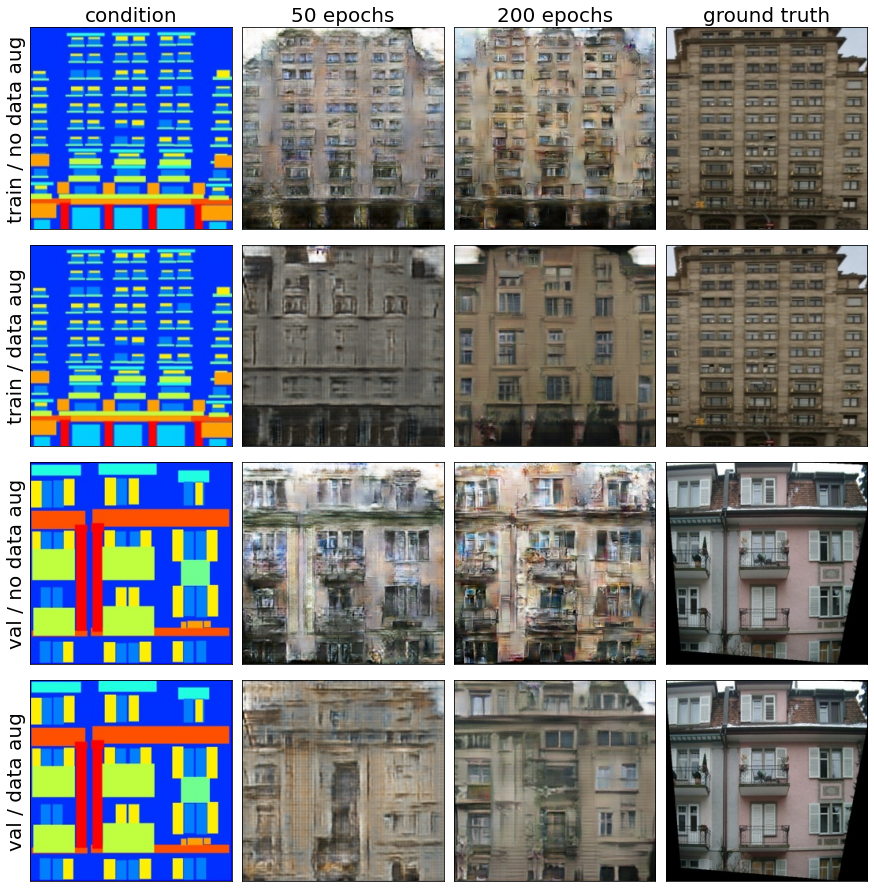

In [17]:
# load model
p2p = model.Pix2Pix().to(utils.device)

fig, axs = plt.subplots(nrows = 4, ncols = 4, figsize=(15,20))

# disable all axis
for ax in axs.flatten(): 
    ax.set_xticks([])
    ax.set_yticks([])

axs[0, 0].imshow(np.clip(input_train.permute(1,2,0).detach().cpu().numpy(), 0, 1))
axs[2, 0].imshow(np.clip(input_val.permute(1,2,0).detach().cpu().numpy(), 0, 1))
axs[1, 0].imshow(np.clip(input_train.permute(1,2,0).detach().cpu().numpy(), 0, 1))
axs[3, 0].imshow(np.clip(input_val.permute(1,2,0).detach().cpu().numpy(), 0, 1))
axs[0, 0].set_ylabel('train / no data aug', size=20)
axs[2, 0].set_ylabel('val / no data aug', size=20)
axs[1, 0].set_ylabel('train / data aug', size=20)
axs[3, 0].set_ylabel('val / data aug', size=20)

axs[0, 3].imshow(np.clip(real_train.permute(1,2,0).detach().cpu().numpy(), 0, 1))
axs[2, 3].imshow(np.clip(real_val.permute(1,2,0).detach().cpu().numpy(), 0, 1))
axs[1, 3].imshow(np.clip(real_train.permute(1,2,0).detach().cpu().numpy(), 0, 1))
axs[3, 3].imshow(np.clip(real_val.permute(1,2,0).detach().cpu().numpy(), 0, 1))

for i, da_mode in enumerate(['', 'da_']):
        for k, ep in enumerate(range(59,200,140)):
            p2p.load_state_dict(torch.load(utils.weights_path + '/' + 'facades_long_' + da_mode + 'ep' + str(ep) + '.pkl'))
            for j, mode in enumerate(['train', 'val']):
                pred_train = p2p.generator(input_train.to(utils.device)[None, :])[0]
                pred_val = p2p.generator(input_val.to(utils.device)[None, :])[0]
                axs[i, 1 + k].imshow(np.clip(pred_train.permute(1,2,0).detach().cpu().numpy(), 0, 1))
                axs[i + 2, 1 + k].imshow(np.clip(pred_val.permute(1,2,0).detach().cpu().numpy(), 0, 1))

axs[0, 0].set_title('condition', size=20)
axs[0, 1].set_title('50 epochs', size=20)
axs[0, 2].set_title('200 epochs', size=20)
axs[0, 3].set_title('ground truth', size=20)

plt.subplots_adjust(wspace=0.05, hspace=-0.5)
plt.savefig(utils.plots_path + '/plot_da_images.png')
plt.show()

## Plot losses with and without data augmentation

In [24]:
# load history with and without data augmentation
file = open(utils.history_path + '/' + dataset_name + '_long.pkl' ,'rb')
file_da = open(utils.history_path + '/' + dataset_name + '_long_da.pkl', 'rb')
history_noda = pickle.load(file)
history_da = pickle.load(file_da)

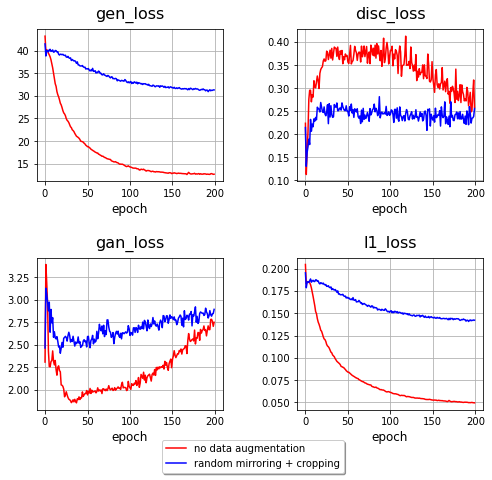

In [62]:
fig, axs = plt.subplots(2, 2, figsize=(8,7))

# plot
for i, ax in enumerate(axs.reshape(-1)):
    ax.grid()
    ax.set_xlabel('epoch', size = 12)
    ylab = ['gen_loss', 'disc_loss', 'gan_loss', 'l1_loss'][i]
    ax.set_title(ylab, size = 16, y = 1.03)
    if i == 0:
        ax.plot(history_noda[ylab], color = 'red', label = 'no data augmentation')
        ax.plot(history_da[ylab], color = 'blue', label = 'random mirroring + cropping')
    else:
        ax.plot(history_noda[ylab], color = 'red')
        ax.plot(history_da[ylab], color = 'blue')

plt.subplots_adjust(wspace=0.4, hspace=0.5)
fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.01),
          fancybox=True, shadow=True)
          
plt.savefig(utils.plots_path + '/plot_da_losses.png', bbox_inches='tight')
plt.show()